In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l
from enum import Enum

In [2]:
def show_trace(results, f, function_string, lr):
    n = max(abs(min(results)), abs(max(results)))
    f_line = tf.range(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results],
             [[f(x) for x in f_line], [f(x) for x in results]], f"x with learning rate {lr}", f"f(x) = {function_string}",
             fmts=['-', '-o'])

In [3]:
def f(x):  # Objective function
    return 10 * (x**2)

def f_grad(x):  # Gradient (derivative) of the objective function
    return 20 * x

In [4]:
def gd(eta, f_grad, epochs):
    x = 5.0
    results = [x]
    for i in range(epochs):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch {epochs}, x: {x:f}')
    return results

In [5]:
def my_gd(eta, f_grad, epochs):
    x = 5.0
    results = [x]
    for i in range(epochs):
        x -= (abs(f_grad(x)) * abs(f_grad(x)) * f_grad(x)) / ((1 + f_grad(x)**2)**2)
        results.append(float(x))
        print(f'epoch {i}, x: {x:f}')
    print(f'epoch {epochs}, x: {x:f}')
    return results

epoch 10, x: 144.627327


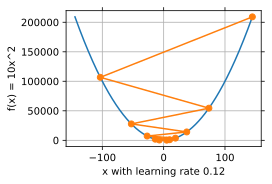

In [6]:
show_trace(gd(0.12, f_grad, 10), f, "10x^2", 0.12)

epoch 10, x: 0.030233


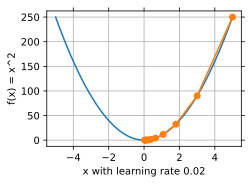

In [7]:
show_trace(gd(0.02, f_grad, 10), f, "x^2", 0.02)

epoch 0, x: 4.990002
epoch 1, x: 4.979984
epoch 2, x: 4.969946
epoch 3, x: 4.959887
epoch 4, x: 4.949809
epoch 5, x: 4.939709
epoch 6, x: 4.929589
epoch 7, x: 4.919448
epoch 8, x: 4.909287
epoch 9, x: 4.899104
epoch 10, x: 4.888900
epoch 11, x: 4.878675
epoch 12, x: 4.868429
epoch 13, x: 4.858161
epoch 14, x: 4.847871
epoch 15, x: 4.837559
epoch 16, x: 4.827226
epoch 17, x: 4.816870
epoch 18, x: 4.806492
epoch 19, x: 4.796092
epoch 20, x: 4.785669
epoch 21, x: 4.775223
epoch 22, x: 4.764755
epoch 23, x: 4.754263
epoch 24, x: 4.743749
epoch 25, x: 4.733211
epoch 26, x: 4.722650
epoch 27, x: 4.712065
epoch 28, x: 4.701456
epoch 29, x: 4.690823
epoch 30, x: 4.680167
epoch 31, x: 4.669486
epoch 32, x: 4.658781
epoch 33, x: 4.648051
epoch 34, x: 4.637296
epoch 35, x: 4.626516
epoch 36, x: 4.615711
epoch 37, x: 4.604881
epoch 38, x: 4.594026
epoch 39, x: 4.583145
epoch 40, x: 4.572238
epoch 41, x: 4.561305
epoch 42, x: 4.550346
epoch 43, x: 4.539360
epoch 44, x: 4.528348
epoch 45, x: 4.51730

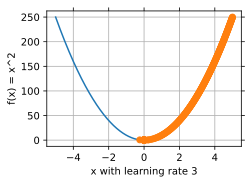

In [8]:
show_trace(my_gd(1, f_grad, 1000), f, "x^2", 3)

In [1]:
from math import sqrt, pi
from numpy import asarray
from numpy import arange, cos, sin, exp
from numpy.random import rand
from numpy.random import seed
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import math
from enum import Enum

In [2]:
def is_equal(a, b, accuracy):
    return abs(a-b) <= accuracy

In [3]:
# # gradient descent algorithm with adadelta
def adadelta(objective, derivative, bounds, n_iter, patience, accuracy, minima, rho, ep=1e-3):
	prev_solution = (-1, -1)
	converged = True
	# track all solutions
	solutions = list()
	# generate an initial point
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# list of the average square gradients for each variable
	sq_grad_avg = [0.0 for _ in range(bounds.shape[0])]
	# list of the average parameter updates
	sq_para_avg = [0.0 for _ in range(bounds.shape[0])]
	# run the gradient descent
	for it in range(n_iter):
		# calculate gradient
		gradient = derivative(solution[0], solution[1])
		# update the average of the squared partial derivatives
		for i in range(gradient.shape[0]):
			# calculate the squared gradient
			sg = gradient[i]**2.0
			# update the moving average of the squared gradient
			sq_grad_avg[i] = (sq_grad_avg[i] * rho) + (sg * (1.0-rho))
		# build solution
		new_solution = list()
		for i in range(solution.shape[0]):
			# calculate the step size for this variable
			alpha = (ep + sqrt(sq_para_avg[i])) / (ep + sqrt(sq_grad_avg[i]))
			# calculate the change
			change = alpha * gradient[i]
			# update the moving average of squared parameter changes
			sq_para_avg[i] = (sq_para_avg[i] * rho) + (change**2.0 * (1.0-rho))
			# calculate the new position in this variable
			value = solution[i] - change
			# store this variable
			new_solution.append(value)
		# store the new solution
		solution = asarray(new_solution)
		solutions.append(solution)
		# evaluate candidate point
		solution_eval = objective(solution[0], solution[1])
		# report progress
		print('&gt;%d f(%s) = %.5f   %s' % (it, solution, solution_eval, prev_solution))
		if (it == n_iter - patience):
			prev_solution = solution
		if (it > n_iter - patience):
			if (is_equal(solution[0], prev_solution[0], accuracy) == False) or (is_equal(solution[1], prev_solution[1], accuracy) == False):
				converged = False
				break
			prev_solution = solution
			
	return solutions, converged, is_equal(prev_solution, minima, accuracy)

In [4]:
def mine_gd(objective, derivative, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, minima, power_factor):
	prev_solution = (-1, -1)
	converged = False
	temp_patience = patience
	epochs_to_converge = 1e7

	solutions = list()
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])

	for it in range(n_iter):

		gradient = derivative(solution[0], solution[1])

		new_solution = list()

		for i in range(solution.shape[0]):
			change = ((abs(gradient[i])**power_factor)/((1 + abs(gradient[i])**2)**power_factor))*gradient[i]

			value = solution[i] - change

			new_solution.append(value)

		solution = asarray(new_solution)
		solutions.append(solution)

		solution_eval = objective(solution[0], solution[1])

		# print('&gt;%d f(%s) = %.5f' % (it, solution, solution_eval))

		if(it == 0):
			prev_solution = solution

		if (is_equal(solution[0], prev_solution[0], convergence_accuracy) == True) and (is_equal(solution[1], prev_solution[1], convergence_accuracy) == True):
			temp_patience = temp_patience - 1
			if temp_patience == 0:
				converged = True
				epochs_to_converge = it + 1
				break
		else:
			temp_patience = patience

		prev_solution = solution
			
	return solutions, converged, all(is_equal(prev_solution, minima, gloabl_accuracy)), epochs_to_converge - patience + 1

In [5]:
def mine_gd_with_momentum(objective, derivative, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, minima, power_factor, momentum):
	prev_solution = (-1, -1)
	converged = False
	temp_patience = patience
	epochs_to_converge = 1e7

	solutions = list()
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])

	prev_velocity = [0]*solution.shape[0]
	
	for it in range(n_iter):

		gradient = derivative(solution[0], solution[1])

		new_solution = list()

		for i in range(solution.shape[0]):

			change = momentum*prev_velocity[i] - ((abs(gradient[i])**power_factor)/((1 + abs(gradient[i])**2)**power_factor))*gradient[i]
			prev_velocity[i] = change
			value = solution[i] + change

			new_solution.append(value)

		solution = asarray(new_solution)
		solutions.append(solution)

		solution_eval = objective(solution[0], solution[1])

		# print('&gt;%d f(%s) = %.5f' % (it, solution, solution_eval))

		if(it == 0):
			prev_solution = solution

		if (is_equal(solution[0], prev_solution[0], convergence_accuracy) == True) and (is_equal(solution[1], prev_solution[1], convergence_accuracy) == True):
			temp_patience = temp_patience - 1
			if temp_patience == 0:
				converged = True
				epochs_to_converge = it + 1
				break
		else:
			temp_patience = patience

		prev_solution = solution
			
	return solutions, converged, all(is_equal(prev_solution, minima, gloabl_accuracy)), epochs_to_converge - patience + 1

In [6]:
def sgd(objective, derivative, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, minima, learning_rate):
	prev_solution = (-1, -1)
	converged = False
	temp_patience = patience
	epochs_to_converge = 1e7

	solutions = list()
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])

	for it in range(n_iter):

		gradient = derivative(solution[0], solution[1])

		new_solution = list()

		for i in range(solution.shape[0]):
			change = learning_rate*gradient[i]

			value = solution[i] - change

			new_solution.append(value)

		solution = asarray(new_solution)
		solutions.append(solution)

		solution_eval = objective(solution[0], solution[1])

		# print('&gt;%d f(%s) = %.5f' % (it, solution, solution_eval))

		if(it == 0):
			prev_solution = solution

		if (is_equal(solution[0], prev_solution[0], convergence_accuracy) == True) and (is_equal(solution[1], prev_solution[1], convergence_accuracy) == True):
			temp_patience = temp_patience - 1
			if temp_patience == 0:
				converged = True
				epochs_to_converge = it + 1
				break
		else:
			temp_patience = patience

		prev_solution = solution
			
	return solutions, converged, all(is_equal(prev_solution, minima, gloabl_accuracy)), epochs_to_converge - patience + 1

In [7]:
def sgd_with_momentum(objective, derivative, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, minima, learning_rate, momentum):
	prev_solution = (-1, -1)
	converged = False
	temp_patience = patience
	epochs_to_converge = 1e7

	solutions = list()
	solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])

	prev_velocity = [0]*solution.shape[0]

	for it in range(n_iter):

		gradient = derivative(solution[0], solution[1])

		new_solution = list()

		for i in range(solution.shape[0]):
			change = momentum*prev_velocity[i] - learning_rate*gradient[i]
			prev_velocity[i] = change
			value = solution[i] + change

			new_solution.append(value)

		solution = asarray(new_solution)
		solutions.append(solution)

		solution_eval = objective(solution[0], solution[1])

		# print('&gt;%d f(%s) = %.5f' % (it, solution, solution_eval))

		if(it == 0):
			prev_solution = solution

		if (is_equal(solution[0], prev_solution[0], convergence_accuracy) == True) and (is_equal(solution[1], prev_solution[1], convergence_accuracy) == True):
			temp_patience = temp_patience - 1
			if temp_patience == 0:
				converged = True
				epochs_to_converge = it + 1
				break
		else:
			temp_patience = patience

		prev_solution = solution
			
	return solutions, converged, all(is_equal(prev_solution, minima, gloabl_accuracy)), epochs_to_converge - patience + 1

In [8]:
from test_functions import BOHACHEVSKY, EASOM, MCCORMICK, THREEHUMP_CAMEL, SPHERE

class TestFunctions(Enum):
    EASOM = EASOM
    BOHACHEVSKY = BOHACHEVSKY
    MCCORMICK = MCCORMICK
    THREEHUMP_CAMEL = THREEHUMP_CAMEL
    SPHERE = SPHERE

In [9]:
def plot2d(solutions, bounds, objective):
    xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
    yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
    x, y = meshgrid(xaxis, yaxis)
    results = objective(x, y)
    f = pyplot.figure()
    f.set_figwidth(5.2)
    f.set_figheight(3)
    pyplot.contourf(x, y, results, levels=50, cmap='jet')
    solutions = asarray(solutions)
    pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')
    pyplot.show()

In [10]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# seeds = [1, 2, 3, 4, 5]
n_iter = 1000
patience = 100
convergence_accuracy = 1e-2
gloabl_accuracy = 1e-1

In [11]:
def convergence_score(converged, is_minima, epochs):
    if(converged == False):
        return 0
    elif(is_minima == True):
        return 10/epochs
    else:
        return 0.2/epochs

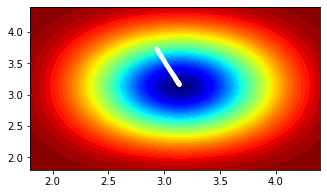

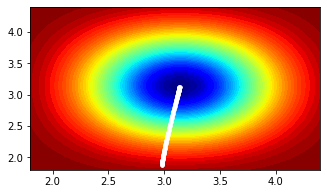

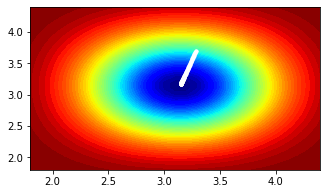

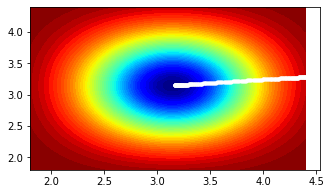

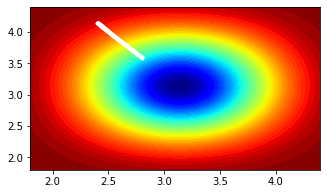

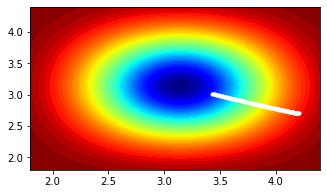

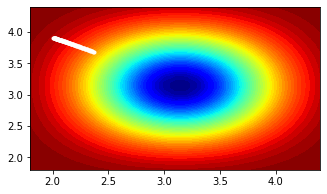

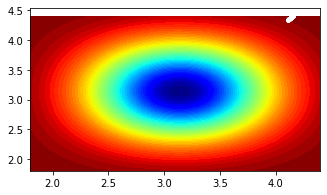

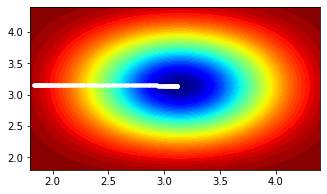

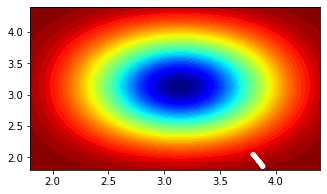

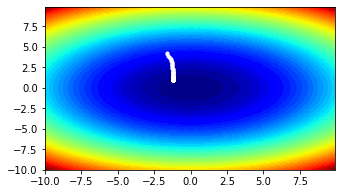

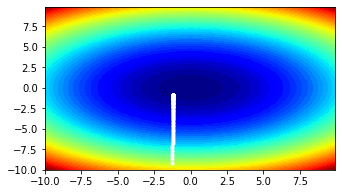

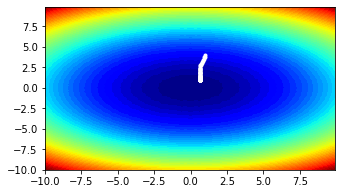

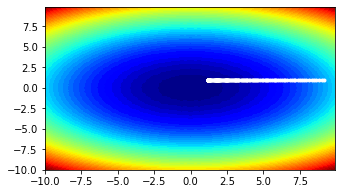

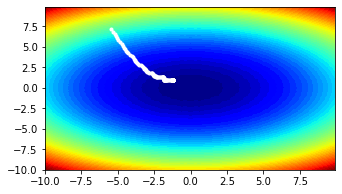

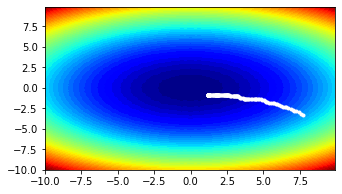

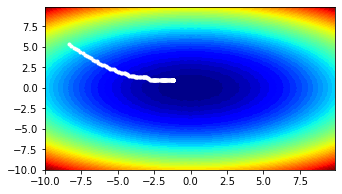

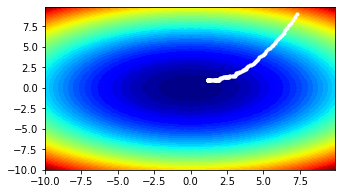

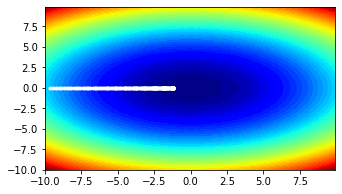

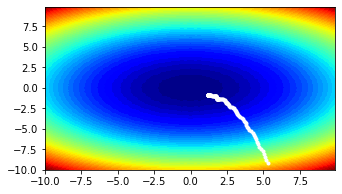

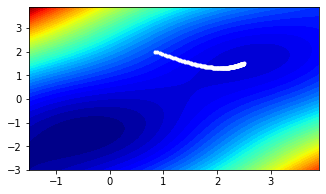

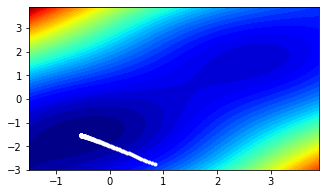

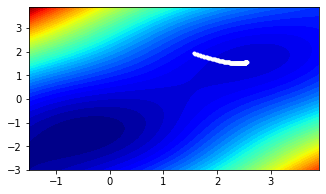

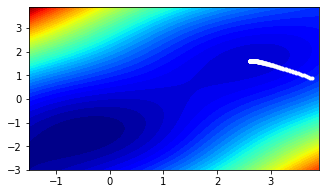

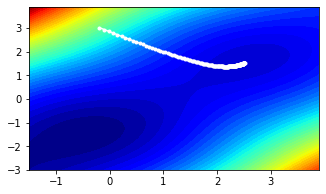

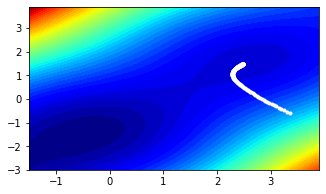

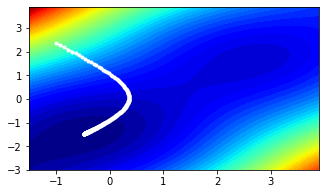

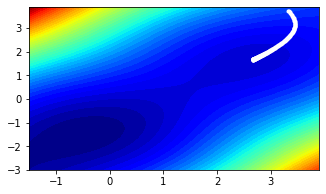

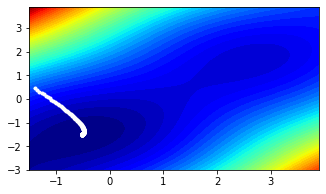

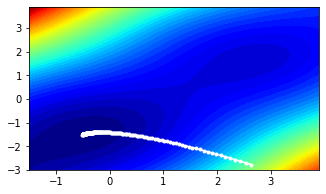

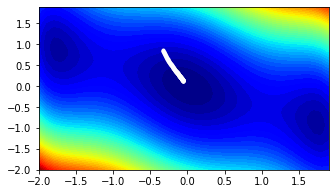

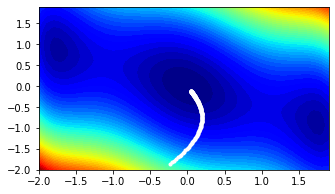

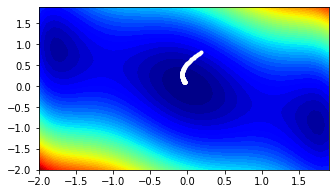

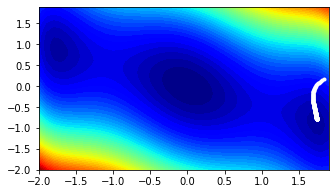

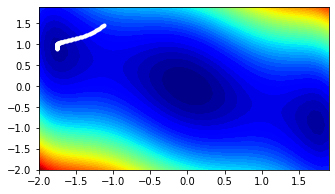

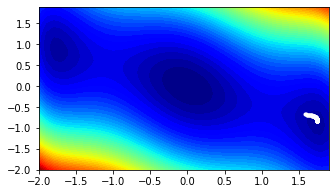

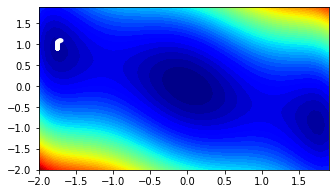

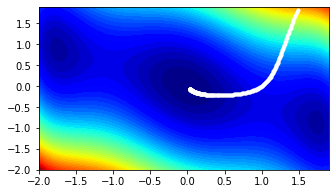

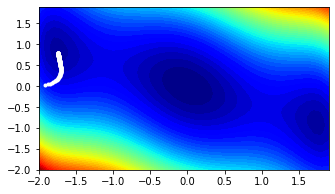

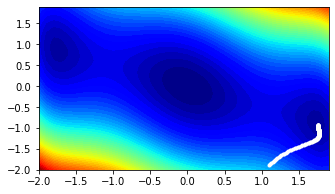

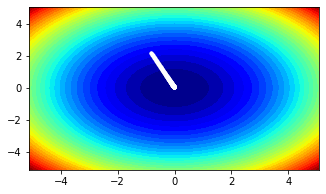

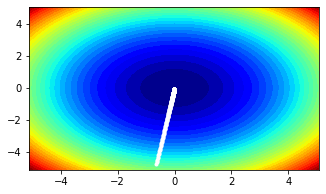

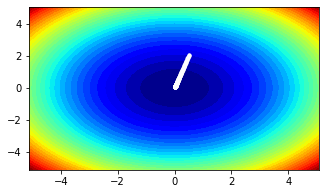

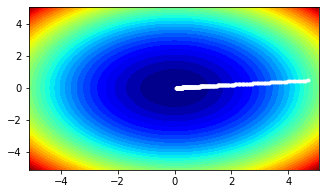

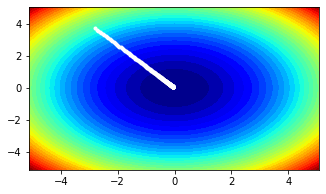

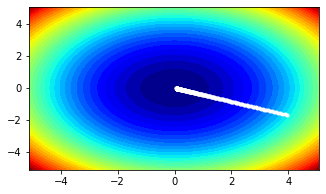

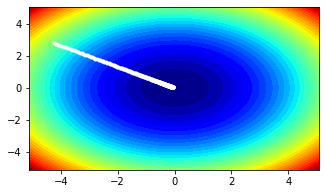

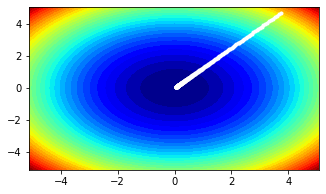

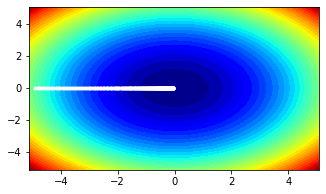

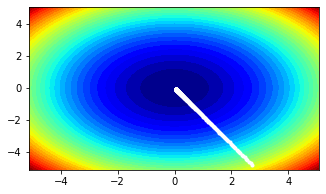

Average score for optimizer:  0.3477551860802626


In [22]:
total_score = 0
for curr_fun in iter(TestFunctions):
    for curr_seed in seeds:
        seed(curr_seed)
        # print(f"Using function: {curr_fun.name} with seed: {curr_seed}")
        bounds = asarray([[curr_fun.value.x1_bounds[0], curr_fun.value.x1_bounds[1]], [curr_fun.value.x2_bounds[0], curr_fun.value.x2_bounds[1]]])

        # solutions, converged, is_minima, epochs_to_converge = mine_gd(curr_fun.value.z, curr_fun.value.df, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, curr_fun.value.minima, power_factor=4)
        # solutions, converged, is_minima, epochs_to_converge = mine_gd_with_momentum(curr_fun.value.z, curr_fun.value.df, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, curr_fun.value.minima, power_factor=3, momentum=0.7)
        solutions, converged, is_minima, epochs_to_converge = sgd(curr_fun.value.z, curr_fun.value.df, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, curr_fun.value.minima, learning_rate=0.01)
        # solutions, converged, is_minima, epochs_to_converge = sgd_with_momentum(curr_fun.value.z, curr_fun.value.df, bounds, n_iter, patience, convergence_accuracy, gloabl_accuracy, curr_fun.value.minima, learning_rate=0.01, momentum=0.9)
        
        # print("Converged: ", converged, "\nConverged at Global Minima: ", is_minima, "\nNumber of epochs required to converge: ", epochs_to_converge)
        score = convergence_score(converged, is_minima, epochs_to_converge)
        total_score = total_score + score
        # print("Score: ", score)
        # plot2d(solutions, bounds, curr_fun.value.z)

average = total_score/(len(list(iter(TestFunctions))) + len(seeds))
print("Average score for optimizer: ", average)